# **`Title: Real and fake face detection using ViT`**

# **Group Members:**

2020/E/034
2020/E/035
2020/E/120

# **`Install Necessary Packages`**

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


# **`Import Libraries`**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from sklearn.metrics import accuracy_score, classification_report
import wandb
from torchsummary import summary
from PIL import Image

In [ ]:
import wandb
from wandb.integration.keras import WandbCallback

In [ ]:
pip install torchsummary

# **`Initialize Wandb`**

In [ ]:
# Initialize wandb
wandb.init(project="fake-face-detection")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **`DataSet Paths Defining`**

In [ ]:

# Define paths
data_dir = "/content/drive/MyDrive/Real and Fake Face Detection Dataset"  # Change this to your dataset path
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

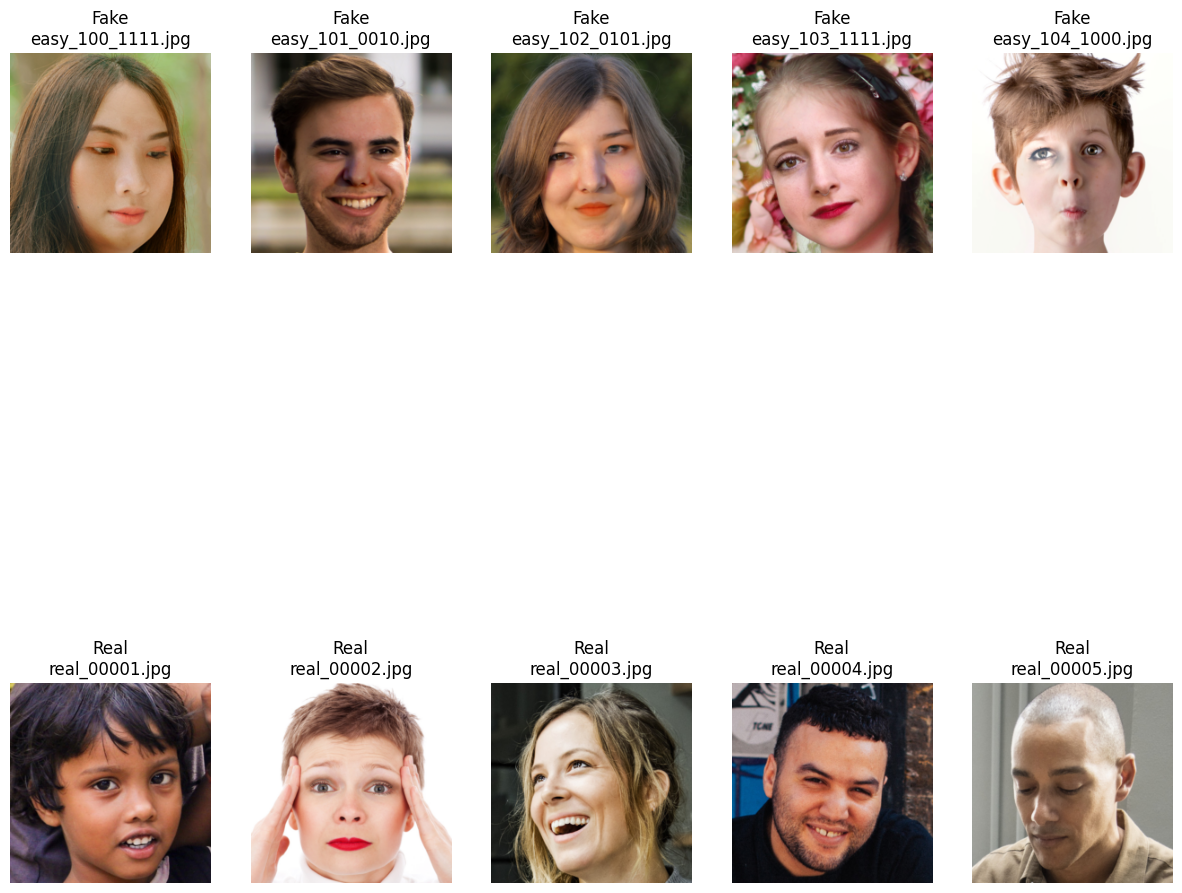

In [ ]:
import os
import matplotlib.pyplot as plt
import torch

# Display some sample images from the training dataset
def show_sample_images(dataset, num_images=10):
    class_count = {cls: 0 for cls in dataset.classes}
    images_to_show = {cls: [] for cls in dataset.classes}

    for i in range(len(dataset)):
        img, label = dataset[i]
        cls_name = dataset.classes[label]
        if class_count[cls_name] < num_images // len(dataset.classes):
            # Get the original file path from the dataset samples
            filename = dataset.samples[i][0]
            images_to_show[cls_name].append((img, label, filename))
            class_count[cls_name] += 1
        if all(count >= num_images // len(dataset.classes) for count in class_count.values()):
            break

    plt.figure(figsize=(15, 15))
    for i, cls_name in enumerate(dataset.classes):
        for j, (img, label, filename) in enumerate(images_to_show[cls_name]):
            ax = plt.subplot(len(dataset.classes), num_images // len(dataset.classes), i * (num_images // len(dataset.classes)) + j + 1)
            ax.axis('off')
            img = img.permute(1, 2, 0)
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img = img.numpy()
            plt.imshow(img)
            ax.set_title(f"{cls_name}\n{os.path.basename(filename)}")
    plt.show()

show_sample_images(train_dataset, num_images=10)


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **`ViT Model Creation`**

In [ ]:
# Define the model
class FaceClassifier(nn.Module):
    def __init__(self):
        super(FaceClassifier, self).__init__()
        self.model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
        self.model.classifier = nn.Linear(self.model.classifier.in_features, 2)

    def forward(self, x):
        return self.model(x).logits

model = FaceClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model summary
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

FaceClassifier(
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
     

In [ ]:
# Define optimizer, criterion and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# **`Train the function with 10 epochs`**

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        all_train_preds = []
        all_train_labels = []
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            if i % 10 == 0:
                print(f"Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = accuracy_score(all_train_labels, all_train_preds)
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                if i % 10 == 0:
                    print(f"Validation Batch {i}/{len(val_loader)}")
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = accuracy_score(all_val_labels, all_val_preds)
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_acc)

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        # Log metrics to wandb
        wandb.log({"Epoch": epoch + 1, "Training Loss": epoch_loss, "Validation Accuracy": epoch_val_acc})

        print(f"Epoch {epoch+1}/{num_epochs} completed, Loss: {epoch_loss:.4f}, Accuracy: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}")

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Starting epoch 1/10
Batch 0/64, Loss: 0.6013
Batch 10/64, Loss: 1.0344
Batch 20/64, Loss: 0.6654
Batch 30/64, Loss: 0.5734
Batch 40/64, Loss: 0.6269
Batch 50/64, Loss: 0.4998
Batch 60/64, Loss: 0.5333
Validation Batch 0/31
Validation Batch 10/31
Validation Batch 20/31
Validation Batch 30/31
Epoch 1/10 completed, Loss: 0.6704, Accuracy: 0.6078, Val Loss: 0.4832, Val Accuracy: 0.7965
Starting epoch 2/10
Batch 0/64, Loss: 0.5893
Batch 10/64, Loss: 0.4405
Batch 20/64, Loss: 0.2598
Batch 30/64, Loss: 0.6598
Batch 40/64, Loss: 0.3771
Batch 50/64, Loss: 0.6225
Batch 60/64, Loss: 0.3150
Validation Batch 0/31
Validation Batch 10/31
Validation Batch 20/31
Validation Batch 30/31
Epoch 2/10 completed, Loss: 0.4184, Accuracy: 0.8140, Val Loss: 0.3468, Val Accuracy: 0.8253
Starting epoch 3/10
Batch 0/64, Loss: 0.3753
Batch 10/64, Loss: 0.1459
Batch 20/64, Loss: 0.1914
Batch 30/64, Loss: 0.1207
Batch 40/64, Loss: 0.2426
Batch 50/64, Loss: 0.4621
Batch 60/64, Loss: 0.2574
Validation Batch 0/31
Validat

# **`Model Accuracy and Loss Plot`**

In [ ]:
# Plot training & validation accuracy and loss curves
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

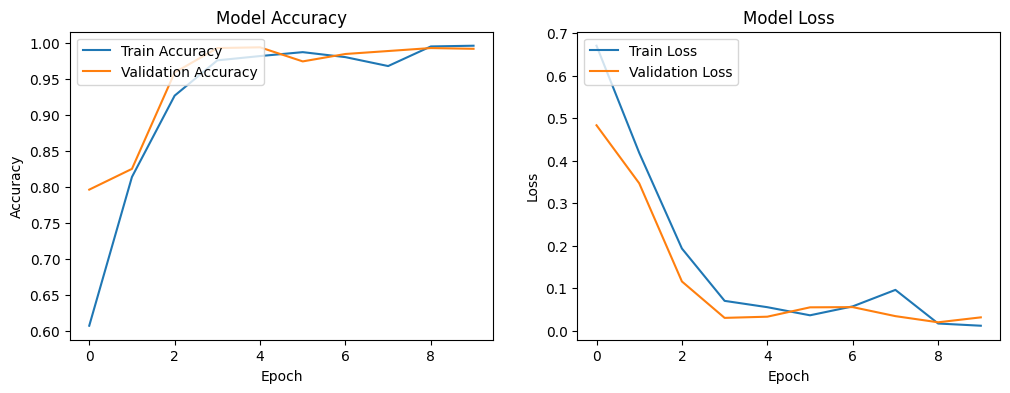

In [ ]:
# Plot accuracy and loss curves
plot_history(history)

In [ ]:
# Plot loss vs epoch
def plot_loss_vs_epoch(history):
    plt.figure()
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Plot accuracy vs epoch
def plot_accuracy_vs_epoch(history):
    plt.figure()
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

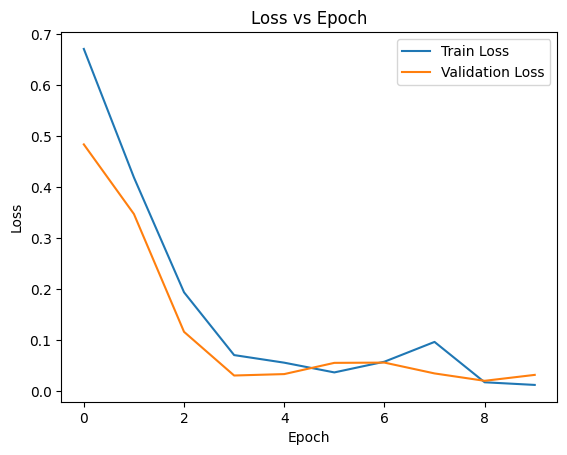

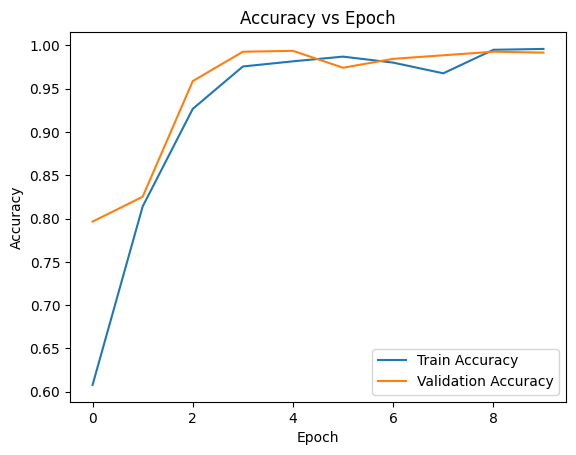

In [ ]:
# Plot loss and accuracy curves separately
plot_loss_vs_epoch(history)
plot_accuracy_vs_epoch(history)

# **`Model Evaluation`**

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    return acc, report

# **`Model Summary`**

In [ ]:
# Evaluate the model
test_acc, test_report = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")
print(test_report)

Test Accuracy: 0.9919
              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99       463
        Real       1.00      0.99      0.99       523

    accuracy                           0.99       986
   macro avg       0.99      0.99      0.99       986
weighted avg       0.99      0.99      0.99       986



# **`Model Testing`**

In [ ]:
# Display sample images with predictions and confidence levels
def show_predictions(model, loader, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 20))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            confidences, preds = torch.max(probs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 5, images_so_far)
                ax.axis('off')
                img = inputs.cpu().data[j]
                img = img.permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.numpy()
                plt.imshow(img)
                ax.set_title(f'Pred: {train_dataset.classes[preds[j]]}\nReal: {train_dataset.classes[labels[j]]}\nConfidence: {confidences[j].item():.2f}')

                if images_so_far == num_images:
                    return

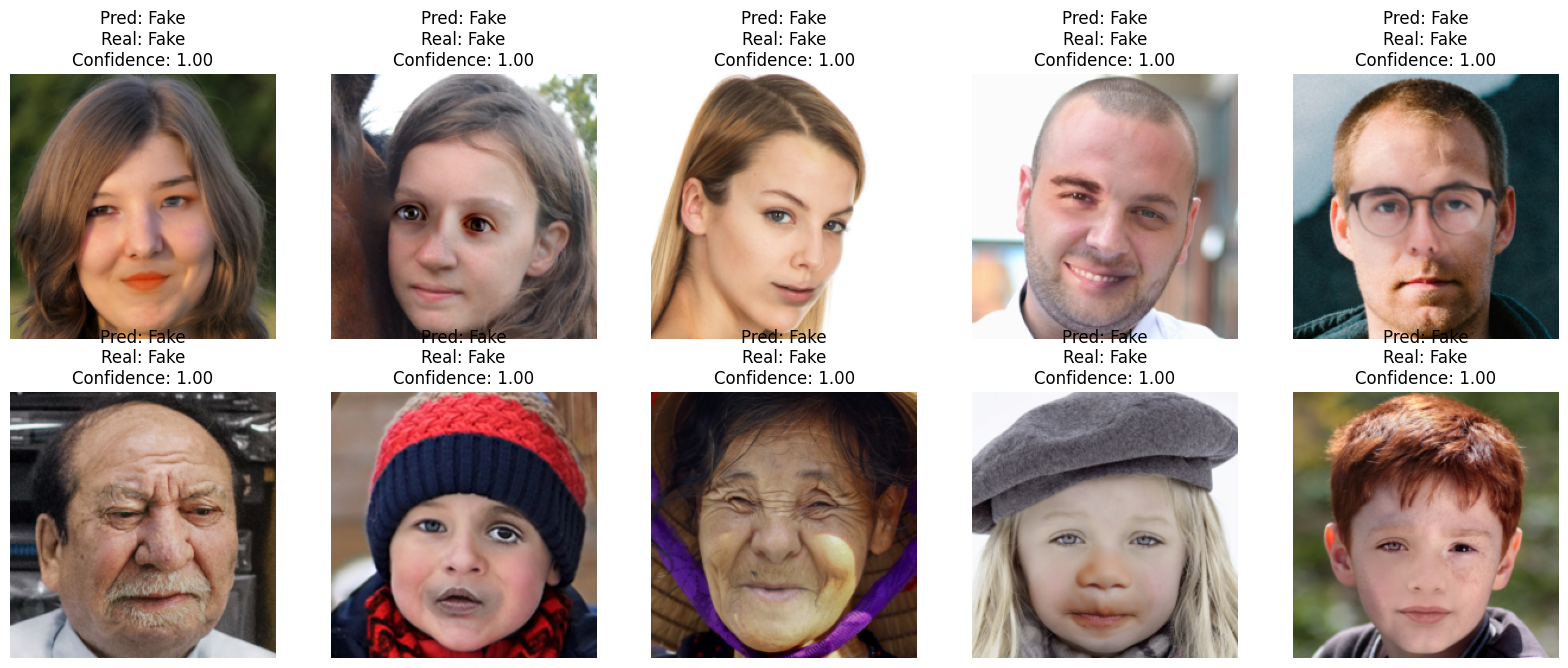

In [ ]:
# Show predictions on validation data with confidence levels
show_predictions(model, val_loader, num_images=10)

# **`Model Evaluation using Confusion Matrix`**

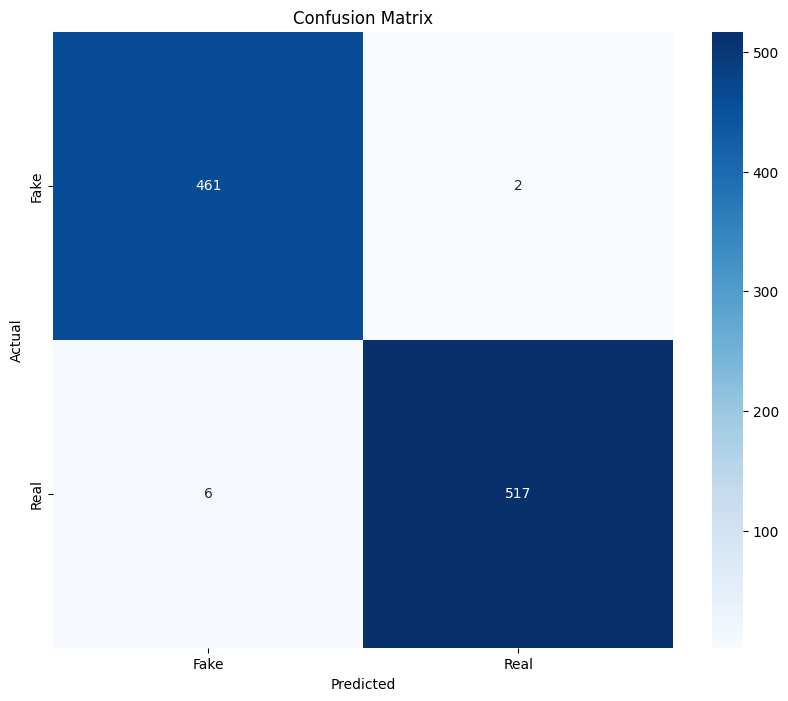

Test Accuracy: 0.9919
              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99       463
        Real       1.00      0.99      0.99       523

    accuracy                           0.99       986
   macro avg       0.99      0.99      0.99       986
weighted avg       0.99      0.99      0.99       986



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluation function with confusion matrix
def evaluate_model_with_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return acc, report

# Evaluate the model and print confusion matrix
class_names = test_dataset.classes
test_acc, test_report = evaluate_model_with_confusion_matrix(model, test_loader, class_names)
print(f"Test Accuracy: {test_acc:.4f}")
print(test_report)


# **`Test New Images Using this Model`**

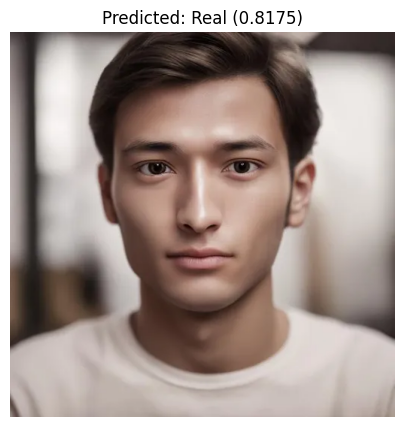

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Function to predict an image and display it
def predict_and_display_image(image_path, model, class_names):
    # Define transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(transformed_image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        confidence = confidence.item()
        predicted_class = predicted_class.item()

    predicted_label = class_names[predicted_class]

    # Display image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

# Example usage
image_path = "/content/drive/MyDrive/image_real"  # Change this to the path of the image you want to test
predict_and_display_image(image_path, model, class_names)


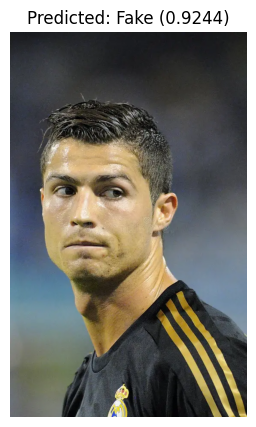

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Function to predict an image and display it
def predict_and_display_image(image_path, model, class_names):
    # Define transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(transformed_image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        confidence = confidence.item()
        predicted_class = predicted_class.item()

    predicted_label = class_names[predicted_class]

    # Display image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

# Example usage
image_path = "/content/drive/MyDrive/cristiano-ronaldo-face"
predict_and_display_image(image_path, model, class_names)


In [ ]:
wandb.init(project="fake-face-detection")